In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']=" "

# 使用库生成验证码训练集，但效果不好所以弃用

# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [20]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
# characters = string.digits + string.ascii_uppercase
characters = string.digits #只有数字

print(characters)

width, height, n_len, n_class = 109, 41, 5, len(characters)

0123456789


# 防止 tensorflow 占用所有显存

In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

# 定义数据生成器

In [194]:
from PIL import Image
import cv2
from PIL.ImageDraw import Draw
from PIL import ImageFilter
table  =  []
for  i  in  range( 256 ):
    table.append( i * 1.97 )
class MyCaptcha(ImageCaptcha):
    def generate_image(self, chars):
        """Generate the image of the given characters.
        :param chars: text to be generated.
        """
        background = (255,255,255)
        color = random_color(10, 200)
        im = self.create_captcha_image(chars, color, background)
#         self.create_noise_dots(im, random_color(238, 255,20))
#         self.create_noise_curve(im, random_color(238, 255,20))
#         im = im.filter(ImageFilter.SMOOTH)
        return im
    
    
    #rewrite func
    def create_captcha_image(self, chars, color, background):
        """Create the CAPTCHA image itself.
        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.
        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        image = Image.new('RGB', (self._width, self._height), background)
        draw = Draw(image)

        def _draw_character(c):
            color=random_color(10,200)
            font = random.choice(self.truefonts)
            w, h = draw.textsize(c, font=font)

#             dx = random.randint(0, 4)
#             dy = random.randint(0, 4)
            dx = 2
            dy = 2
            im = Image.new('RGBA', (w, h),(255,255,255,0))
            Draw(im).text((0, 0), c, font=font, fill=color)
            im=im.crop((1,10,im.size[0]-1,im.size[1]-1))
#             im.show()

            # rotate
#             im = im.crop(im.getbbox())
            im = im.rotate(random.uniform(0,20), expand=1)

            # warp
            dx = w * random.uniform(0.1, 0.3)
            dy = h * random.uniform(0.2, 0.3)
#             dy = h * random.uniform(0.02, 0.2)

            x1 = int(random.uniform(-dx, dx))
            y1 = int(random.uniform(-dy, dy))
            x2 = int(random.uniform(-dx, dx))
            y2 = int(random.uniform(-dy, dy))
            w2 = w + abs(x1) + abs(x2)
            h2 = h + abs(y1) + abs(y2)
            data = (
                x1, y1,
                -x1, h2 - y2,
                w2 + x2, h2 + y2,
                w2 - x2, -y1,
            )
            im = im.resize((w2, h2),Image.ANTIALIAS)
            im = im.transform((w, h), Image.QUAD, data)
#             im = im.resize((im.size[0], int(im.size[1]/2)))

            mask=Image.new('RGBA',im.size,(255,)*4)
            im=Image.composite(im,mask,im)
            p=self._height/im.size[1]
            im=im.resize((int(im.size[0]*p),self._height))
            return im

        images = []
        for c in chars:
# 等距生成
#             if random.random() > 0.5:
#             images.append(_draw_character(" "))
            images.append(_draw_character(c))

        text_width = sum([im.size[0] for im in images])

        width = max(text_width, self._width)
        image = image.resize((width, self._height),Image.ANTIALIAS)

        average = int(text_width / len(chars))
        rand = int(0.25 * average)
        offset = int(average * 0.1)

        for im in images:
            im=im.resize((im.size[0],int(im.size[1]*(2/3))),Image.ANTIALIAS)
            w, h = im.size
#             mask = im.convert('L').point(table)
#             mask = Image.new('RGBA')
#             image.paste(im, (offset, int((self._height - h) / 2)), mask)
            image.paste(im, (offset, int((self._height - h) / 2)))


            offset = offset + w
#             offset = offset + w -rand

        if width > self._width:
            image = image.resize((self._width, self._height),Image.ANTIALIAS)
        return image
def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)

In [195]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=5, width=109, height=41):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = MyCaptcha(width=width, height=height,fonts=['./test/fonts/ARIALNB.ttf'])
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0 #NNNNNN
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

# 测试生成器

In [2]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=10, steps=5)
X, y = data[3]
print(X.shape)
plt.imshow(X[1])
print(y)
plt.title(decode(y))

NameError: name 'CaptchaSequence' is not defined

# 定义网络结构

In [202]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

# 网络结构可视化

可视化需要安装下面的包：

```sh
pip install pydot
sudo apt install graphviz
```

In [203]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# plot_model(model, to_file='cnn.png', show_shapes=True)
# Image('cnn.png')

In [204]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 41, 109, 3)   0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 41, 109, 32)  896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 41, 109, 32)  128         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 41, 109, 32)  0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
conv2d_41 

# 训练模型

In [205]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=500)
valid_data = CaptchaSequence(characters, batch_size=128, steps=50)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])


In [206]:
model.fit_generator(train_data, epochs=1, workers=4,validation_data=valid_data)
# model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
#                     callbacks=callbacks)

Epoch 1/1
500/500 [==============================] - 482s 964ms/step - loss: 0.7818 - c1_loss: 0.1615 - c2_loss: 0.1496 - c3_loss: 0.1522 - c4_loss: 0.1518 - c5_loss: 0.1667 - c1_acc: 0.9473 - c2_acc: 0.9524 - c3_acc: 0.9513 - c4_acc: 0.9513 - c5_acc: 0.9452 - val_loss: 0.0058 - val_c1_loss: 9.8410e-04 - val_c2_loss: 0.0012 - val_c3_loss: 0.0011 - val_c4_loss: 0.0012 - val_c5_loss: 0.0013 - val_c1_acc: 1.0000 - val_c2_acc: 1.0000 - val_c3_acc: 1.0000 - val_c4_acc: 1.0000 - val_c5_acc: 1.0000


In [80]:
model.save('result.h5')

### 载入最好的模型继续训练一会

In [9]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0586 - c1_loss: 0.0135 - c2_loss: 0.0160 - c3_loss: 0.0155 - c4_loss: 0.0136 - c1_acc: 0.9946 - c2_acc: 0.9937 - c3_acc: 0.9940 - c4_acc: 0.9948 - val_loss: 0.0601 - val_c1_loss: 0.0147 - val_c2_loss: 0.0165 - val_c3_loss: 0.0169 - val_c4_loss: 0.0120 - val_c1_acc: 0.9951 - val_c2_acc: 0.9939 - val_c3_acc: 0.9935 - val_c4_acc: 0.9952
Epoch 2/100
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0550 - c1_loss: 0.0118 - c2_loss: 0.0153 - c3_loss: 0.0152 - c4_loss: 0.0127 - c1_acc: 0.9954 - c2_acc: 0.9942 - c3_acc: 0.9940 - c4_acc: 0.9949 - val_loss: 0.0578 - val_c1_loss: 0.0118 - val_c2_loss: 0.0172 - val_c3_loss: 0.0156 - val_c4_loss: 0.0132 - val_c1_acc: 0.9956 - val_c2_acc: 0.9928 - val_c3_acc: 0.9937 - val_c4_acc: 0.9948
Epoch 3/100
1000/1000 [==============================] - 118s 118ms/step - loss: 0.0527 - c1_loss: 0.0119 - c2_loss: 0.0144 - c3_loss: 0.0149 - c4_loss: 0.0115 - 

In [10]:
model.load_weights('cnn_best.h5')

# 测试模型

(-0.5, 108.5, 40.5, -0.5)

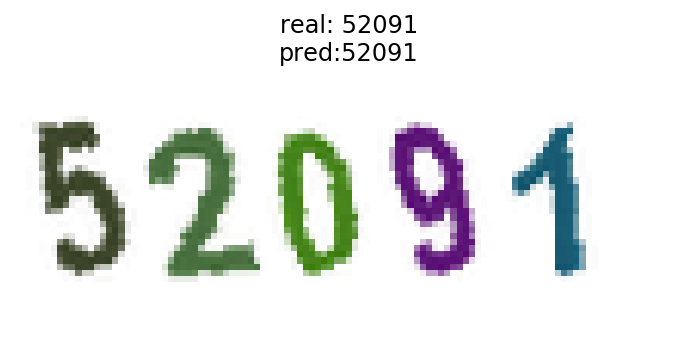

In [209]:
X, y = data[0]
# print(X[0])
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [12]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


0.98265625

# 保存模型

In [13]:
model.save('cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

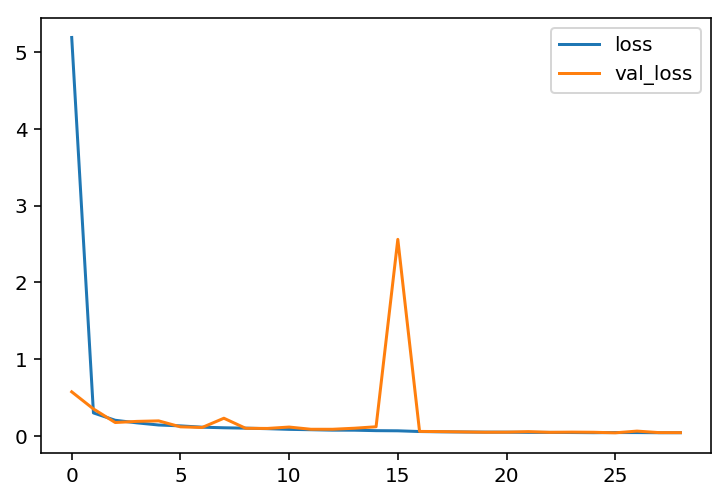

In [14]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

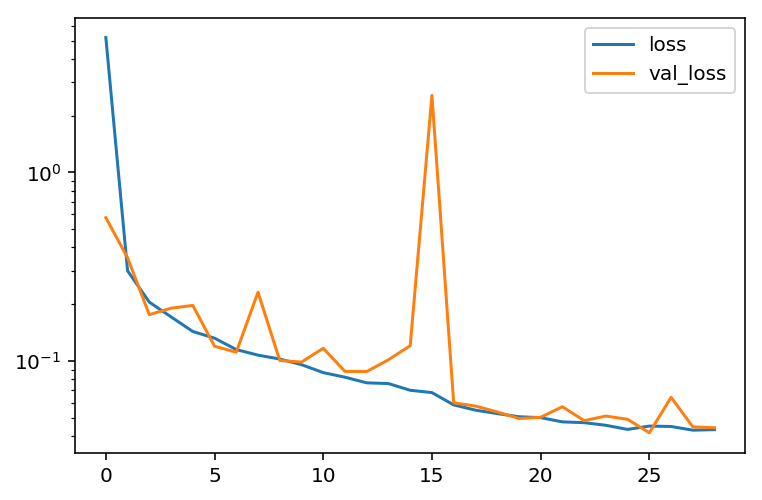

In [15]:
df[['loss', 'val_loss']].plot(logy=True)

In [11]:
from tensorflow.keras.models import load_model
model=load_model('./result.h5')

In [18]:
te=Image.open('./test/3.jpg')
te.convert('L')
print(np.array(te))

[[[219 219 219]
  [221 221 221]
  [222 222 222]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [250 250 250]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [251 251 251]
  [236 236 236]
  ...
  [252 252 252]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[220 220 220]
  [220 220 220]
  [220 220 220]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


(-0.5, 108.5, 40.5, -0.5)

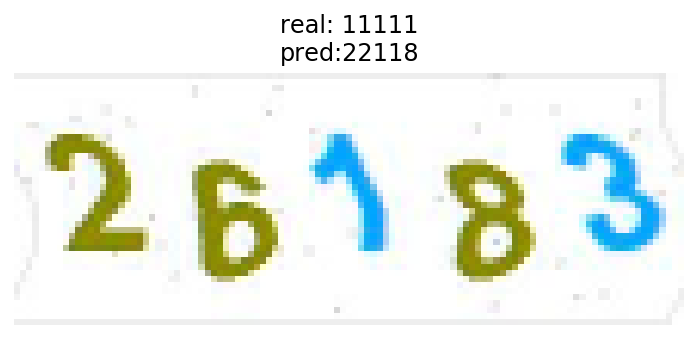

In [216]:
import cv2
a=cv2.imread('./test/6.jpg')
a=cv2.resize(a,(109,41))
a=a.reshape((1,41,109,3))
a=a/255
plt.imshow(a[0])
re = model.predict(a)
plt.title('real: %s\npred:%s'%('11111', decode(re)))
# plt.imshow(a[0], cmap='gray')
plt.axis('off')

In [ ]:
def show_img(img):
    

In [105]:
a=np.array([[1,2,3],[4,5,6]])
a[1:]=a[1:]/3
a

array([[1, 2, 3],
       [1, 1, 2]])